In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from starfish.set import settings

In [3]:
def var_filter(fisher,lcdm,neff_fixed):
    df=fisher.copy()
    if lcdm:
        df=df.drop('w0',axis=0)
        df=df.drop('w0',axis=1)
        df=df.drop('wa',axis=0)
        df=df.drop('wa',axis=1)
    if neff_fixed:
        df=df.drop('N_eff',axis=0)
        df=df.drop('N_eff',axis=1)

    return df

# DESI QSO

In [4]:
DESI_QSO=[]
for redshift in settings.z_DESI_QSO:
    df=pd.DataFrame(np.loadtxt(f'../data/DESI_QSO/DESI_{redshift:.1f}.csv',delimiter=','),index=settings.name_DESI_QSO,columns=settings.name_DESI_QSO)
    DESI_QSO.append(var_filter(df,lcdm=True,neff_fixed=True))

In [5]:
DESI_QSO_valid=[]
for fisher in DESI_QSO:
    fisher_valid=fisher.copy()
    for index in fisher_valid.index:
        if (fisher_valid.loc[index,:]==0).all():
            fisher_valid=fisher_valid.drop(index,axis=0)
            fisher_valid=fisher_valid.drop(index,axis=1)
    cov=pd.DataFrame(np.linalg.inv(fisher_valid.values),index=fisher_valid.index,columns=fisher_valid.columns)
    DESI_QSO_valid.append(np.linalg.inv(cov.iloc[:settings.cosmo_num,:settings.cosmo_num].values))

In [6]:
from getdist import plots
from getdist.gaussian_mixtures import GaussianND

gauss = []
for f in DESI_QSO_valid:
    g = GaussianND(settings.cosmo_value, f, is_inv_cov=True, names=settings.var_exp)
    g.paramNames.names[-1].name = r"$\sum m_{\nu,\mathrm{eff}}\;[\mathrm{eV}]$"
    g.paramNames.names[-1].label = ""
    g.names = settings.var_exp
    gauss.append(g)

In [7]:
import seaborn as sns
palette=sns.color_palette('rocket_r',n_colors=len(DESI_QSO_valid))
palette

[(0.96516917, 0.70776351, 0.5606593),
 (0.95381595, 0.46373781, 0.31769923),
 (0.8833417, 0.19830556, 0.26014181),
 (0.67824099, 0.09192342, 0.3504148),
 (0.43860848, 0.12177004, 0.34119475),
 (0.20973515, 0.09747934, 0.24238489)]

In [8]:
orders=[r'$h$',r'$\sigma_8$',r'$\sum m_{\nu,\mathrm{eff}}\;[\mathrm{eV}]$',]
m=dict(zip(settings.var_exp,settings.cosmo_value))
err=[]
for f in DESI_QSO_valid:
    cov=np.linalg.inv(f)
    err.append(np.sqrt(np.diag(cov)))
err_max=np.sort(np.stack(err,axis=0),axis=0)[-1,:]
limits=list(zip(settings.cosmo_value-2*err_max,settings.cosmo_value+2*err_max))
d=dict(zip(settings.var_exp,limits))

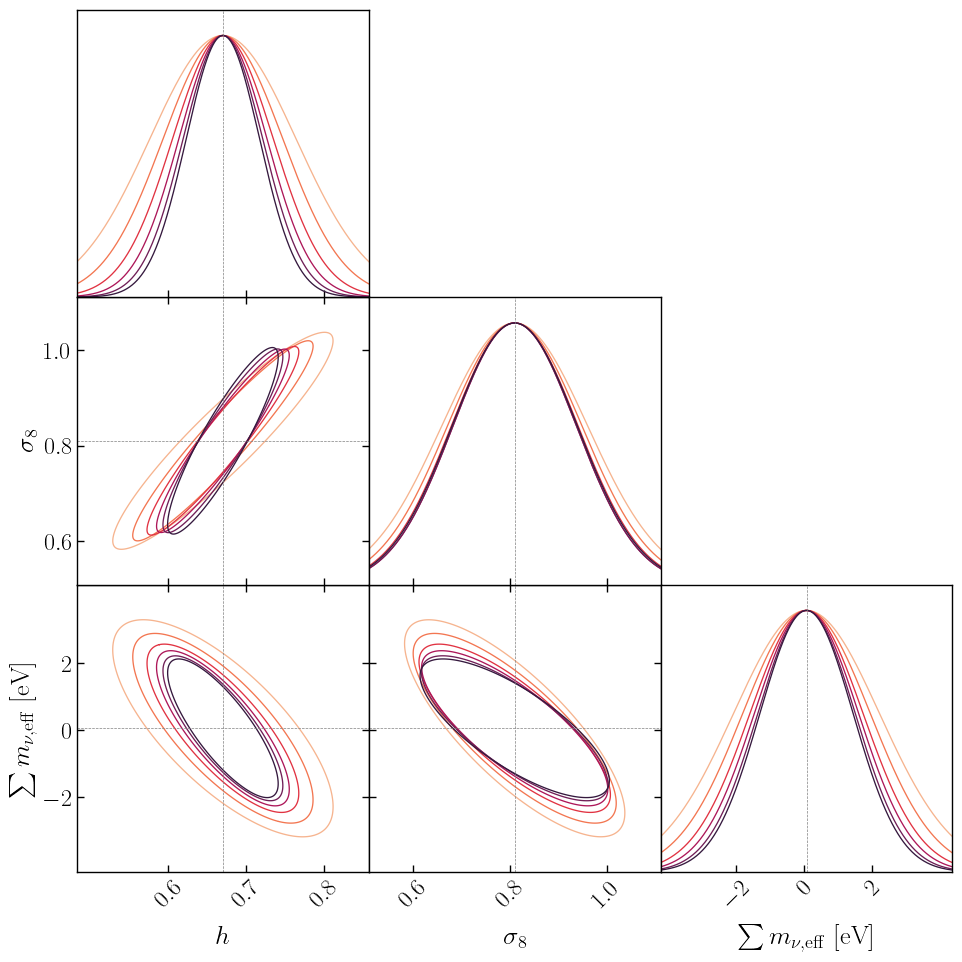

In [9]:
sns.set_context('paper',font_scale=2)
ploter=plots.get_subplot_plotter(width_inch=10,rc_sizes=True)
ploter.settings.tight_layout=True
ploter.settings.axis_tick_x_rotation=45
ploter.settings.figure_legend_frame=False
ploter.settings.num_plot_contours=1
ploter.triangle_plot(
    gauss,
    params=orders,
    param_limits=d,
    filled=False,
    markers=m,
    marker_args={'color':'gray'},
    legend_labels=[],
    contour_colors=palette,
    contour_ls='-',
    legend_loc='upper right')

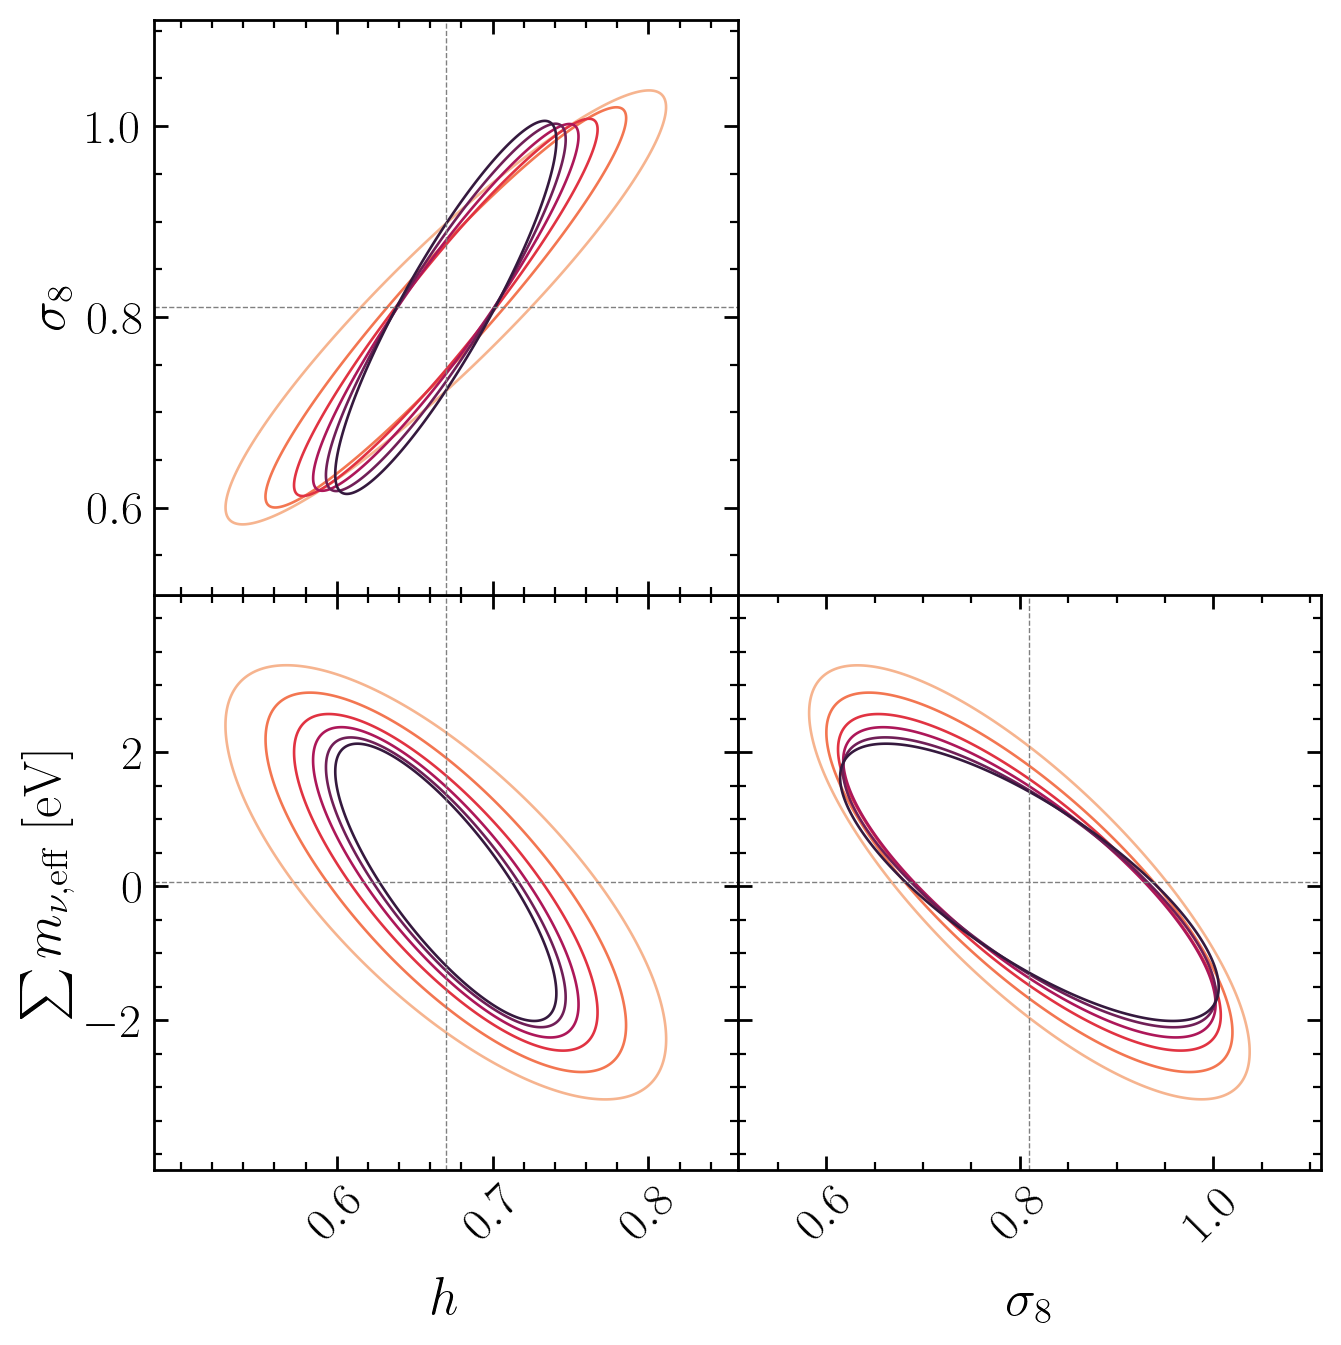

In [10]:
ploter.fig.set_dpi(200)
ploter.fig.align_labels()
for ax in ploter.fig.axes:
    ax.minorticks_on()
    ax.tick_params(which='major',length=5)
    ax.tick_params(which='minor',length=3)
y=len(orders)
axes=[]
start=0
for x in range(len(orders)):
    axes.append(ploter.fig.axes[start:start+y])
    start+=y
    y-=1
for col in axes:
    col[-1].set_visible(False)
ploter.fig.subplots_adjust(wspace=0.,hspace=0.)
ploter.fig

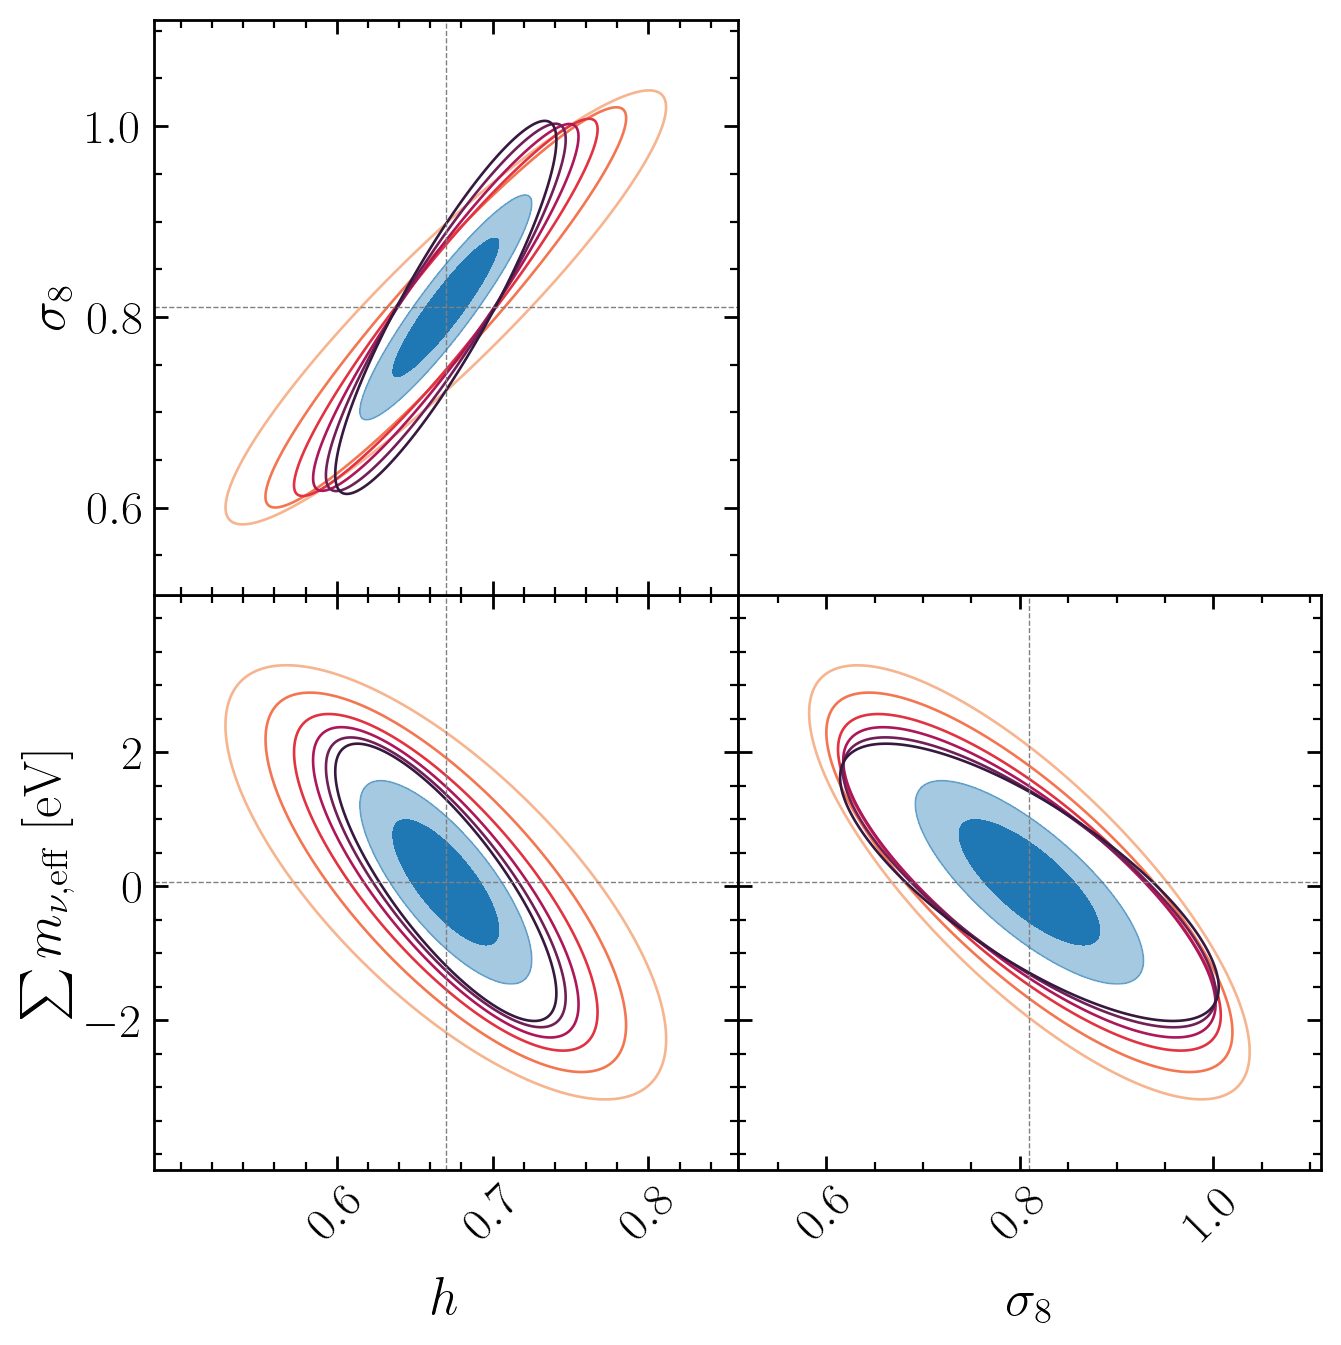

In [11]:
DESI_QSO_all=var_filter(pd.read_excel(f'../data/DESI_QSO/fisher.xlsx',index_col=0,header=0),lcdm=True,neff_fixed=True)
cov_all=pd.DataFrame(np.linalg.inv(DESI_QSO_all.values),index=DESI_QSO_all.index,columns=DESI_QSO_all.columns)
array=cov_all.iloc[:settings.cosmo_num,:settings.cosmo_num]
g=GaussianND(settings.cosmo_value,array,is_inv_cov=False,names=settings.var_exp)
g.paramNames.names[-1].name=r'$\sum m_{\nu,\mathrm{eff}}\;[\mathrm{eV}]$'
g.paramNames.names[-1].label=''
g.names=settings.var_exp

ploter.settings.num_plot_contours=2
i=0
pair=[[r'$h$',r'$\sum m_{\nu,\mathrm{eff}}\;[\mathrm{eV}]$'],[r'$h$',r'$\sigma_8$'],[r'$\sigma_8$',r'$\sum m_{\nu,\mathrm{eff}}\;[\mathrm{eV}]$']]
for col in axes:
    for ax in col[:-1]:
        ploter.add_2d_contours(
            g,
            param_pair=pair[i],
            ax=ax,
            filled=True,
            color='#1F77B4',
        )
        i+=1
ploter.fig

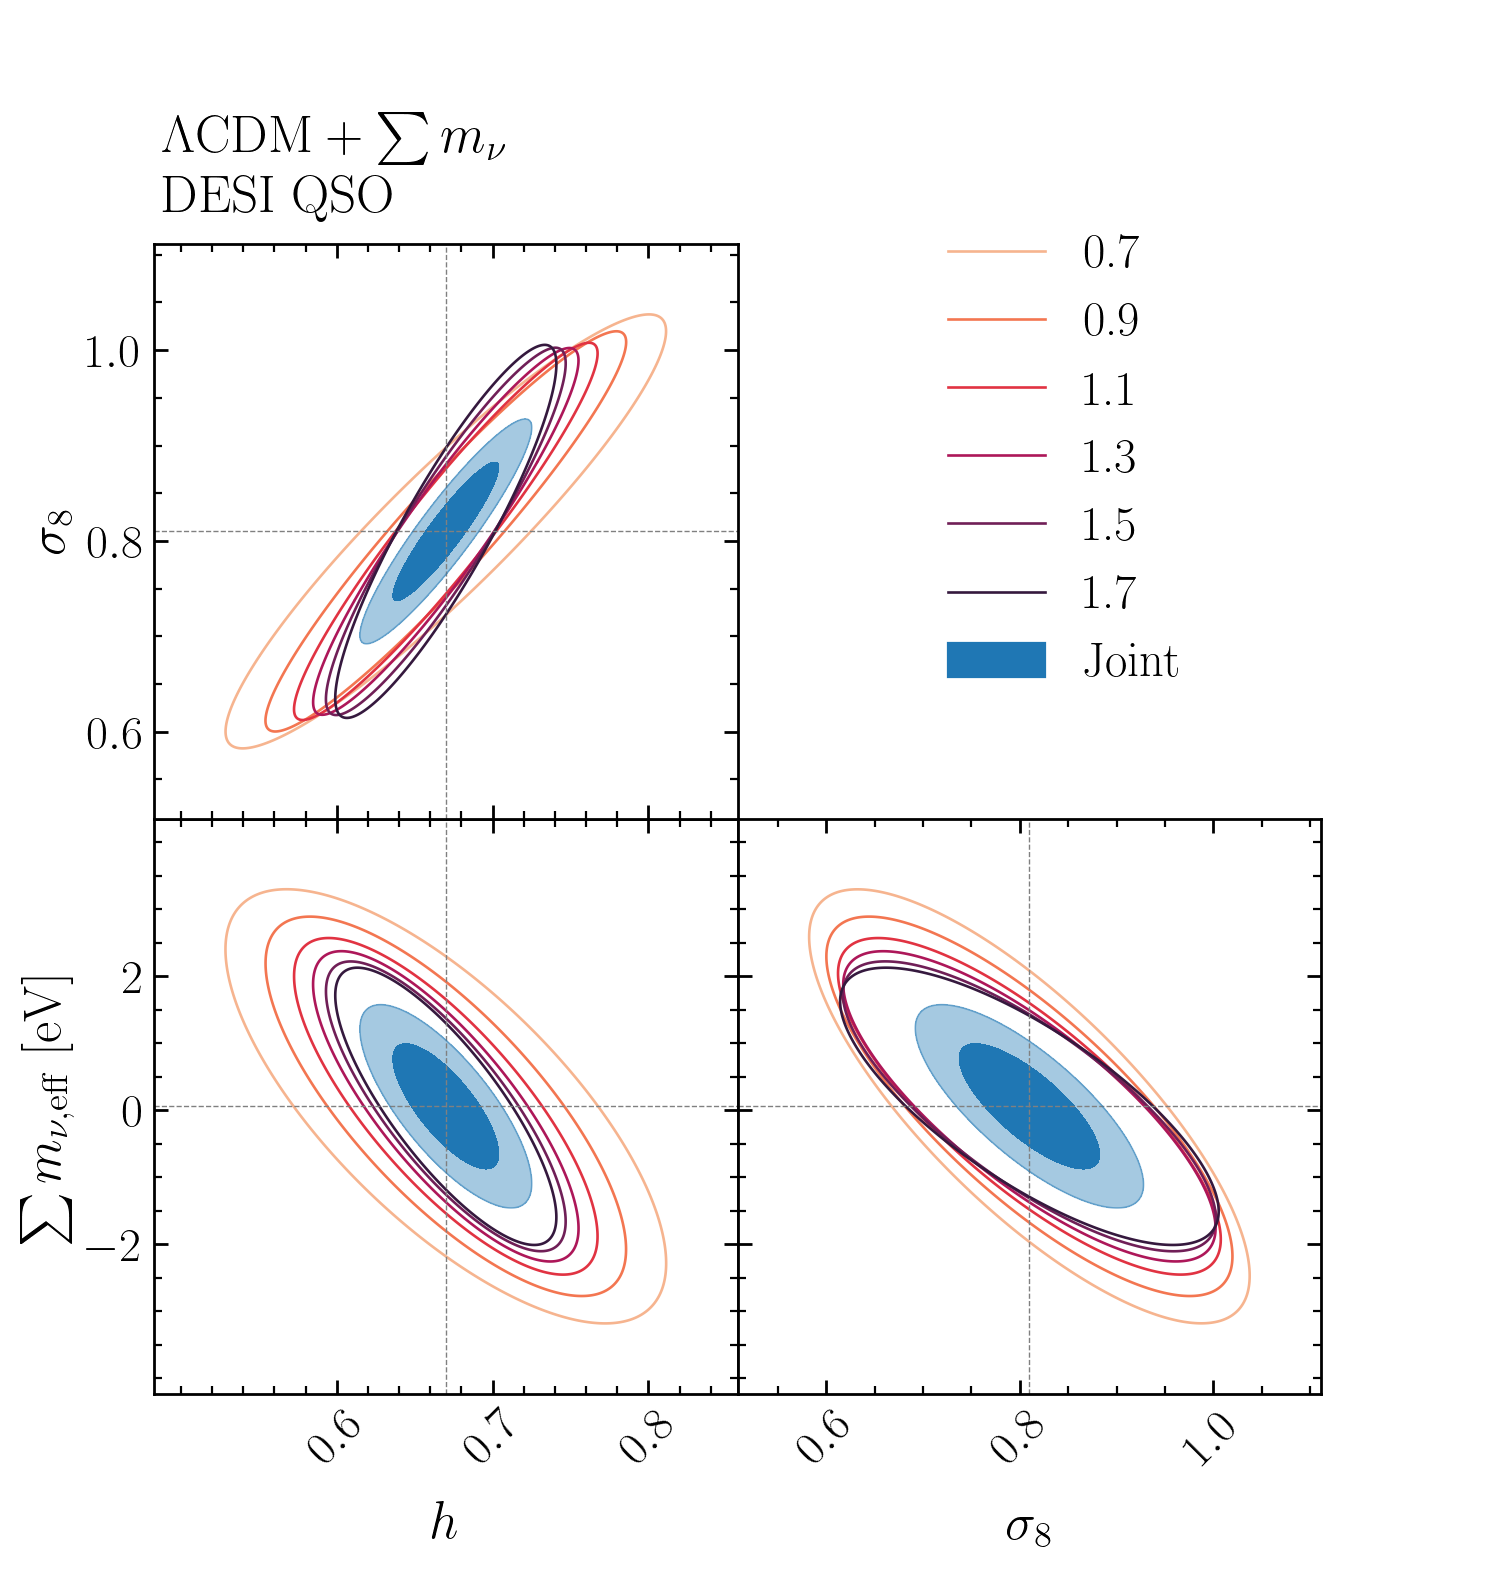

In [12]:
legend=[f'{z:.1f}' for z in settings.z]+['Joint']
from matplotlib.patches import Patch
p=Patch(color='#1F77B4')
ploter.fig.legend(axes[0][-1].get_lines()[:len(legend)-1]+[p],legend,loc=(0.62,0.55),frameon=False)
ploter.fig.text(0.1,0.73,r'$\Lambda\mathrm{CDM}+\sum m_\nu$')
ploter.fig.text(0.1,0.7,'DESI QSO')
ploter.fig

In [13]:
ploter.fig.savefig('../fig/dqso-z-lcdm-fixed.pdf',bbox_inches='tight')